In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Réseau de neurones

Si X est un ensemble de données et Y un ensemble d'étiquettes (ou classes) associées à chaque donnée, l'apprentissage automatique a pour objectif d'approximer la fonction (inconnue) qui à une donnée associe son étiquette. Par exemple, X peut être un ensemble d'images (`X[i]` est une image, c'est à dire un rectangle de pixels), et Y peut servir à distinguer les photos de chats (`Y[i]` vaut 1 si `X[i]` représente un chat, 0 sinon). <br>

Un réseau de neurones est une façon possible d'approximer cette fonction inconnue, en assemblant un certain nombre de fonctions plus simples selon un réseau (ou graphe orienté). <br>
La régression logistique (voir, par exemple: https://github.com/fortierq/ML/blob/master/logistic.ipynb) est un cas particulier de réseau de neurones, avec un seul neurone.

Voici un exemple plus intéressant de réseau de neurones:
![DNN](img/dnn.png)

Le réseau est décomposé en plusieurs **couches** (ici 3): les éléments de la couche $i$ sont indiqués par un exposant $i$. <br>
Tous les éléments $x$, $y$, $z$, $w$ contiendront une valeur réelle. <br>
L'entrée de ce réseau est une donnée $X$ composée de deux éléments $x_0$ et $x_1$ (les *features*). La sortie est un seul réel $y$. <br>
Chaque arête possède un **poids** $w$. Chaque neurone possède de plus un **biais** $b$. <br>
Chaque variable $z$ correspond à l'entrée (impulsion) d'un sommet (aussi appelé **neurone**). <br>
Chaque $y$ est la sortie (réponse) d'un neurone, qui est fonction du $z$ correspondant. Ici, on utilisera $y = \sigma(z)$ où $\sigma(z) = \frac{1}{1 + e^{-z}}$ est la fonction **sigmoïde**. <br> 
Remarque: $\sigma$ est très utilisé en machine learning car elle est différentiable (essentiel pour l'algorithme de backpropagation décrit plus bas) et a ses valeurs entre 0 et 1 (permettant d'interpréter $y$ comme une probabilité). Il existe cependant de nombreuses fonctions d'activations possibles, comme $\tanh$, relu...<br>
On utilisera aussi $\sigma'$ qui vérifie, après calcul: $\sigma'(z) = \sigma(z)(1 - \sigma(z))$.

In [3]:
def s(x): # sigmoïde
    return 1/(1 + np.exp(-x))
def ds(x): # dérivée de la sigmoïde
    return s(x)*(1 - s(x))

# Forward propagation

On calcule $y$ à partir de $x_0$ et $x_1$ (*forward propagation*) couche par couche:
- $z_{\bullet}^0 \longleftarrow x_0 w_{0, \bullet}^0 + x_1 w_{0, \bullet}^0 + b_{\bullet}^0 ~~~$ (pour $\bullet = 0, 1$) 
- $y_{\bullet}^0 \longleftarrow \sigma(z_{\bullet}^0) ~~~$ (pour $\bullet = 0, 1$) 
- $z_{\bullet}^1 \longleftarrow y_0^0 w_{0, \bullet}^1 + y_1^0 w_{0, \bullet}^1 + b_{\bullet}^1 ~~~$ (pour $\bullet = 0, 1$) 
- $y_{\bullet}^1 \longleftarrow \sigma(z_{\bullet}^1) ~~~$ (pour $\bullet = 0, 1$) 
- ainsi de suite...

Implémentons cette *forward propagation*, sous forme matricielle (les calculs sous forme vectoriel sont parallélisables, donc beaucoup plus rapides). <br>
Pour cela, notons $W^i$ la matrice des coefficients $w^i$ pour la couche $i$. Par exemple:
$$W^0 = \begin{pmatrix}
w_{0, 0}^0 & w_{0, 1}^0\\
w_{1, 0}^0 & w_{1, 1}^0
\end{pmatrix}$$
Dans le cas général, les couches peuvent avoir des tailles différentes $n_0$, $n_1$, ..., $n_l$. $W^i$ est alors de taille $n_i \times n_{i+1}$. <br>
Définissons les vecteurs lignes:
$$Y^i = \begin{pmatrix}
y_{0}^i & y_{1}^i & ...\\
\end{pmatrix}$$
$$Z^i = \begin{pmatrix}
z_{0}^i & z_{1}^i & ...\\
\end{pmatrix}$$
$$B^i = \begin{pmatrix}
b_{0}^i & b_{1}^i & ...\\
\end{pmatrix}$$
$$X = \begin{pmatrix}
x_{0} & x_{1} & ...\\
\end{pmatrix}$$
Remarque: il est possible d'utiliser des vecteurs colonnes, comme c'est le cas dans le cours https://www.coursera.org/specializations/deep-learning, mais l'utilisation de vecteurs lignes me semble simplifier certains passages.

La *forward propagation* devient alors:
$$Z^i \longleftarrow Y^{i-1} W^i + B^i$$
$$Y^i \longleftarrow \sigma(Z^i)$$
Pour faciliter l'induction, on pose $Y^{-1} = X$ et $Y^l = Y$. <br>
Dans l'implémentation ci-dessous, `L_W`, `L_B`, `L_Z`, `L_Y` contiennent les listes des $W^i$, $B^i$, $Z^i$, $Y^i$, pour les différentes couches. `@` est le produit matriciel.

In [20]:
def forward(X, L_W, L_B):
    L_Z = []
    L_Y = [X]
    for i in range(len(L_W)):
        L_Z.append(L_Y[-1] @ L_W[i] + L_B[i])
        L_Y.append(s(L_Z[-1]))
    return L_Z, L_Y 

On peut donc calculer la réponse `y` du réseau de neurone à une donnée `X` comme le dernier élément de `L_Y`:

In [21]:
def predict(X, L_W, L_b):
    return forward(X, L_W, L_b)[1][-1]

Cette réponse, entre 0 et 1, sera interprêté comme la probabilité que X soit de classe 1. Si cette réponse est supérieure à 0.5, on prédira la classe 1 pour X, et la classe 0 sinon.

# Vectorialisation

En pratique, on va vouloir calculer la réponse d'un réseau de neurones à plusieurs données (et même: toutes les données). On pourrait appliquer `forward` plusieurs mais, encore une fois, il est plus efficace de vectorialiser: si les données sont $X_1$, $X_2$, ... (vecteurs lignes), on utilise:
$$X = \begin{pmatrix}
- X_1 -\\
- X_2 -\\
...
\end{pmatrix}$$
Grâce à la magie des tableaux numpy (broadcasting et opérations terme à terme), on peut appliquer la même fonction `forward` à une telle matrice $X$ et obtenir une matrice des réponses $Y_i$ à chaque $X_i$, sous la forme: 
$$Y = \begin{pmatrix}
- Y_1 -\\
- Y_2 -\\
...
\end{pmatrix}$$

# Positionnement du problème

L'objectif est maintenant de trouver des valeurs pour les coefficients $w$ et $b$ qui permettent de prédire correctement la classe d'une donnée. <br>
Exemple: considérons quatres données $(1, 1), (-1, 1), (-1, -1), (1, -1)$ (des points) de classes 1, 0, 1, 0.

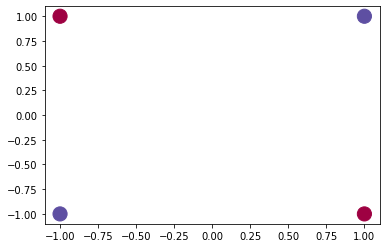

In [22]:
X = np.array([[1, 1], [-1, 1], [-1, -1], [1, -1]])
Y = np.array([[1], [0], [1], [0]]) # vraies classes
plt.scatter(X[:, 0], X[:, 1], c = Y, cmap = plt.cm.Spectral, s = 200)

In [23]:
def init(L_sz): # L_sz contient le nombre de neurones de chaque couche
    L_W, L_B = [], []
    for i in range(len(L_sz) - 1):
        L_W.append(np.random.randn(L_sz[i], L_sz[i + 1]))
        L_B.append(np.zeros((1, L_sz[i + 1])))
    return L_W, L_B

In [24]:
L_W, L_B = init([2, 2, 1]) # même architecture que celle donnée au début du notebook
predict(X, L_W, L_B)

array([[0.38808765],
       [0.43755769],
       [0.44911844],
       [0.39926921]])

Comme les poids ont été choisis aléatoirement, les réponses du réseau de neurones ne sont absolument pas pertinentes.

# Optimisation

L'idée va être de modifier itérativement les valeurs de $w$ et $b$ de façon à améliorer les réponses du réseau de neurones. <br>
Pour cela, il faut quantifier l'erreur commise par le réseau de neurones. C'est le rôle de la **fonction de coût** (ou **loss**). <br>
Le choix de fonction de coût le plus classique pour les problèmes de classification binaire est la *binary cross-entropy*:

In [25]:
def loss(A, Y):
    return -np.sum(Y*np.log(A) + (1 - Y)*np.log(1 - A))

`A` est la prédiction réalisée et `Y` la vraie réponse. Cette fonction punit une réponse d'autant plus qu'elle est éloignée de la bonne (par exemple, si `Y` vaut 1, `np.log(A)` tend vers $- \infty$ quand `A` se rapproche de 0).

In [221]:
def backprop(L_W, L_b, L_Z, L_Y, Y, alpha = 0.1):
    for l in range(len(L_W) - 1, -1, -1):
        if l == len(L_W) - 1:
            dZ = L_Y[l + 1] - Y
        else:
            dZ = (dZ @ L_W[l + 1].T) * ds(L_Z[l])
        dW = L_Y[l].T @ dZ
        db = np.sum(dZ)
        L_W[l] -= alpha*dW
        L_b[l] -= alpha*db

In [222]:
def dnn(X, Y, L_sz, epochs, alpha = 0.1):
    L_W, L_b = init(L_sz)
    for i in range(epochs):
        L_Z, L_Y = forward(X, L_W, L_b)
        if i % (epochs//10) == 0:
            print("Loss (i = ", i, "): ", loss(L_Y[-1], Y), sep="")
            #print(L_Y[-1])
        backprop(L_W, L_b, L_Z, L_Y, Y, alpha)
    return L_W, L_b

In [223]:
X = np.array([[1, 1], [-1, 1], [-1, -1], [1, -1]])
Y = np.array([[1], [0], [1], [0]])
Y = np.array([[1], [1], [0], [0]])

In [229]:
L_b[0]

array([[-0.02802803, -0.02802803, -0.02802803, -0.02802803]])

In [225]:
L_W, L_b = dnn(X, Y, [2, 4, 1], 1000)

Loss (i = 0): 2.5288529630711647
Loss (i = 100): 0.2104032513855601
Loss (i = 200): 0.09061780048288606
Loss (i = 300): 0.05667822632936005
Loss (i = 400): 0.04097913984654773
Loss (i = 500): 0.03199319591059269
Loss (i = 600): 0.02619255033253182
Loss (i = 700): 0.02214645165134443
Loss (i = 800): 0.019167184989144718
Loss (i = 900): 0.01688396459924287


In [226]:
n = 1000
X = np.random.randn(n, 2)
Y = (X[:, :1] * X[:, 1:] > 0).astype(int)

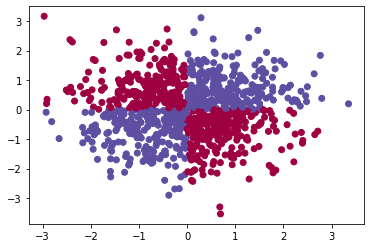

In [227]:
plt.scatter(X[:, 0], X[:, 1], c = Y, cmap = plt.cm.Spectral)

In [228]:
X_train, X_test = X[:len(X)//2], X[len(X)//2:]
Y_train, Y_test = Y[:len(Y)//2], Y[len(Y)//2:]
L_W, L_b = dnn(X_train, Y_train, [2, 4, 4, 2, 1], 10000, 0.001)

Loss (i = 0): 352.03911320983843
Loss (i = 1000): 274.8636456187578
Loss (i = 2000): 27.281947095088267
Loss (i = 3000): 14.129898231844535
Loss (i = 4000): 7.916589752526226
Loss (i = 5000): 4.957248734199765
Loss (i = 6000): 3.4181225413653387
Loss (i = 7000): 2.5222253809185395
Loss (i = 8000): 1.9557944119741812
Loss (i = 9000): 1.575316566721141


In [220]:
Y_pred = np.int64(np.round(predict(X_test, L_W, L_b)).flatten())
Y_test_flat = Y_test.flatten()
print(Y_pred)
print(Y_test_flat)
print("Accuracy: ", np.sum(Y_pred == Y_test_flat)/len(Y_pred))

[1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 1 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1
 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 1
 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0
 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 1
 0 1 0 0 1 1 0 1 0 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1
 0 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 1
 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1
 0 0 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0
 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 0
 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1
 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1
 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1
 0 0 1 1 1 1 0 0 0 1 1 0 